# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
# silence NumbaPerformanceWarning
import warnings
from numba.errors import NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.2 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Load FBM progen lineage

In [4]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/bm_plus_19pcw/data/bm_plus_19pcw_raw_dr_20200414.h5ad')

In [5]:
adata.raw = adata

In [6]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T                        327
CD8 T                        171
CD14 monocyte               8787
CD56 bright NK               540
CMP                          425
DC1                           50
DC2                          598
DC3                          705
DC precursor                 201
EI macrophage                 92
ELP                         1358
GMP                         1285
HSC                           92
ILC precursor                 67
Immature B cell             1998
MEMP                          16
MEP                          269
MK                          1036
MPP lymphoid                  34
MPP myeloid 1                 46
MPP myeloid 2                 46
NKT                          137
Naive B cell                1423
Pre B progenitor           14234
Pre pro B progenitor        5428
Pro B progenitor            5530
Treg                          62
adipo-CAR                    359
arteriolar fibroblast         84
basophil                     13

In [7]:
progen_celltypes_1 = ['HSC', 'MEMP', 
                    'MPP myeloid 1', 'MPP myeloid 2', 
                   'MPP lymphoid']

progen_celltypes_2 = ['early erythroid', 'MEP', 'early MK', 'eo/baso/mast precursor',
                    'neut myeloid', 'CMP', 'GMP',
                   'ELP', 'Pre pro B progenitor']

In [8]:
adata_1 = adata[adata.obs['cell.labels'].isin(progen_celltypes_1)].copy()
adata_2 = adata[adata.obs['cell.labels'].isin(progen_celltypes_2)].copy()

In [9]:
cell_numbers = adata_1.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
HSC              92
MEMP             16
MPP lymphoid     34
MPP myeloid 1    46
MPP myeloid 2    46
dtype: int64

In [10]:
cell_numbers = adata_2.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CMP                        425
ELP                       1358
GMP                       1285
MEP                        269
Pre pro B progenitor      5428
early MK                  1665
early erythroid           7534
eo/baso/mast precursor     175
neut myeloid              4184
dtype: int64

In [11]:
tot_adata = anndata.AnnData
for i in adata_2.obs["cell.labels"].unique().tolist():
    print(i)
    subset = adata_2[adata_2.obs["cell.labels"].isin([i])].copy()
    print(subset.shape)
    sc.pp.subsample(subset, n_obs = 70)
    tot_adata = tot_adata.concatenate(subset, join='outer', index_unique=None)

early erythroid
(7534, 33712)
ELP
(1358, 33712)
Pre pro B progenitor
(5428, 33712)
neut myeloid
(4184, 33712)
MEP
(269, 33712)
GMP
(1285, 33712)
early MK
(1665, 33712)
eo/baso/mast precursor
(175, 33712)
CMP
(425, 33712)


In [12]:
cell_numbers = tot_adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CMP                       70
ELP                       70
GMP                       70
MEP                       70
Pre pro B progenitor      70
early MK                  70
early erythroid           70
eo/baso/mast precursor    70
neut myeloid              70
dtype: int64

In [13]:
merged = adata_1.concatenate(tot_adata, index_unique=None, join='inner')
adata=merged

In [14]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CMP                       70
ELP                       70
GMP                       70
HSC                       92
MEMP                      16
MEP                       70
MPP lymphoid              34
MPP myeloid 1             46
MPP myeloid 2             46
Pre pro B progenitor      70
early MK                  70
early erythroid           70
eo/baso/mast precursor    70
neut myeloid              70
dtype: int64

In [15]:
adata.shape

(864, 33712)

# Pre-process the dataset

In [16]:
# normalise count data 
sc.pp.normalize_total(adata)

In [17]:
# log the count data 
sc.pp.log1p(adata)

In [18]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [19]:
# scale the data 
sc.pp.scale(adata, max_value=10)

In [20]:
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

In [21]:
# run pca
sc.tl.pca(adata, n_comps=50)

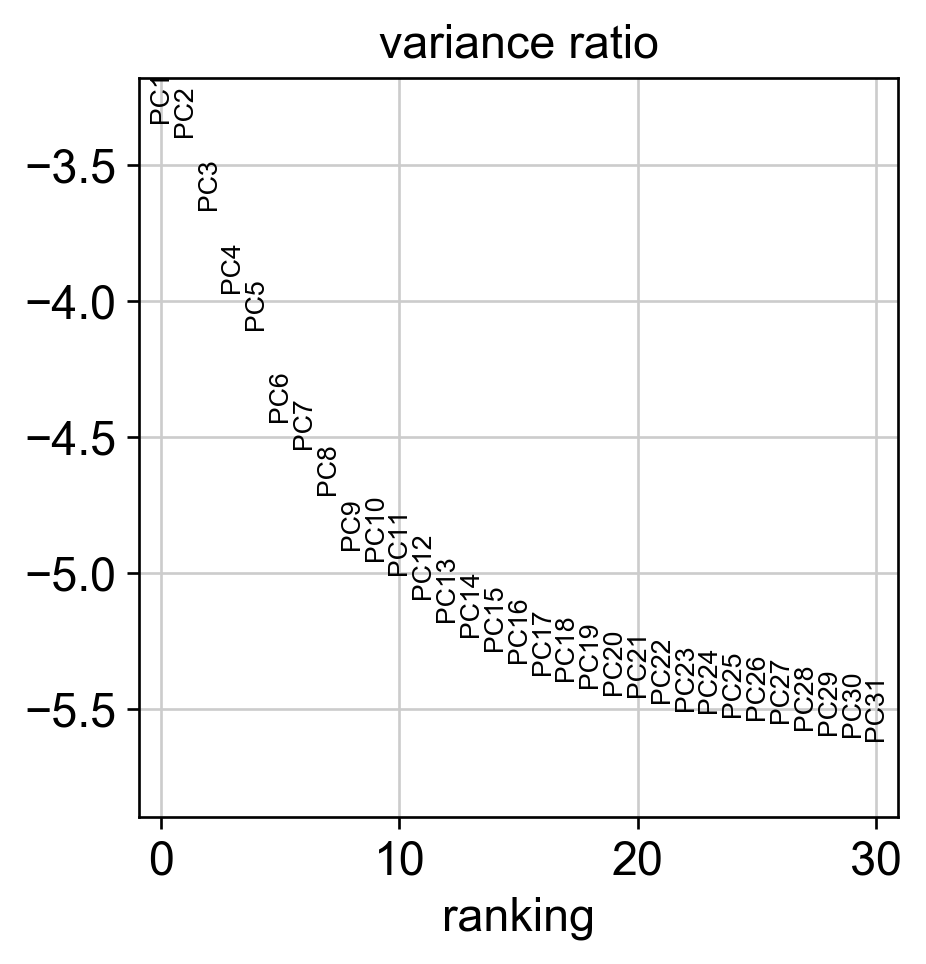

In [22]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [23]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=10) 

In [24]:
# run umap
sc.tl.umap(adata) 

... storing 'april_cell.labels' as categorical
... storing 'cell.labels' as categorical
... storing 'doublets' as categorical
... storing 'fetal.ids' as categorical
... storing 'gender' as categorical
... storing 'is_doublet' as categorical
... storing 'is_doublet_poptrim' as categorical
... storing 'is_doublet_wolock' as categorical
... storing 'lanes' as categorical
... storing 'orig.ident' as categorical
... storing 'processing.type' as categorical
... storing 'sort.ids' as categorical


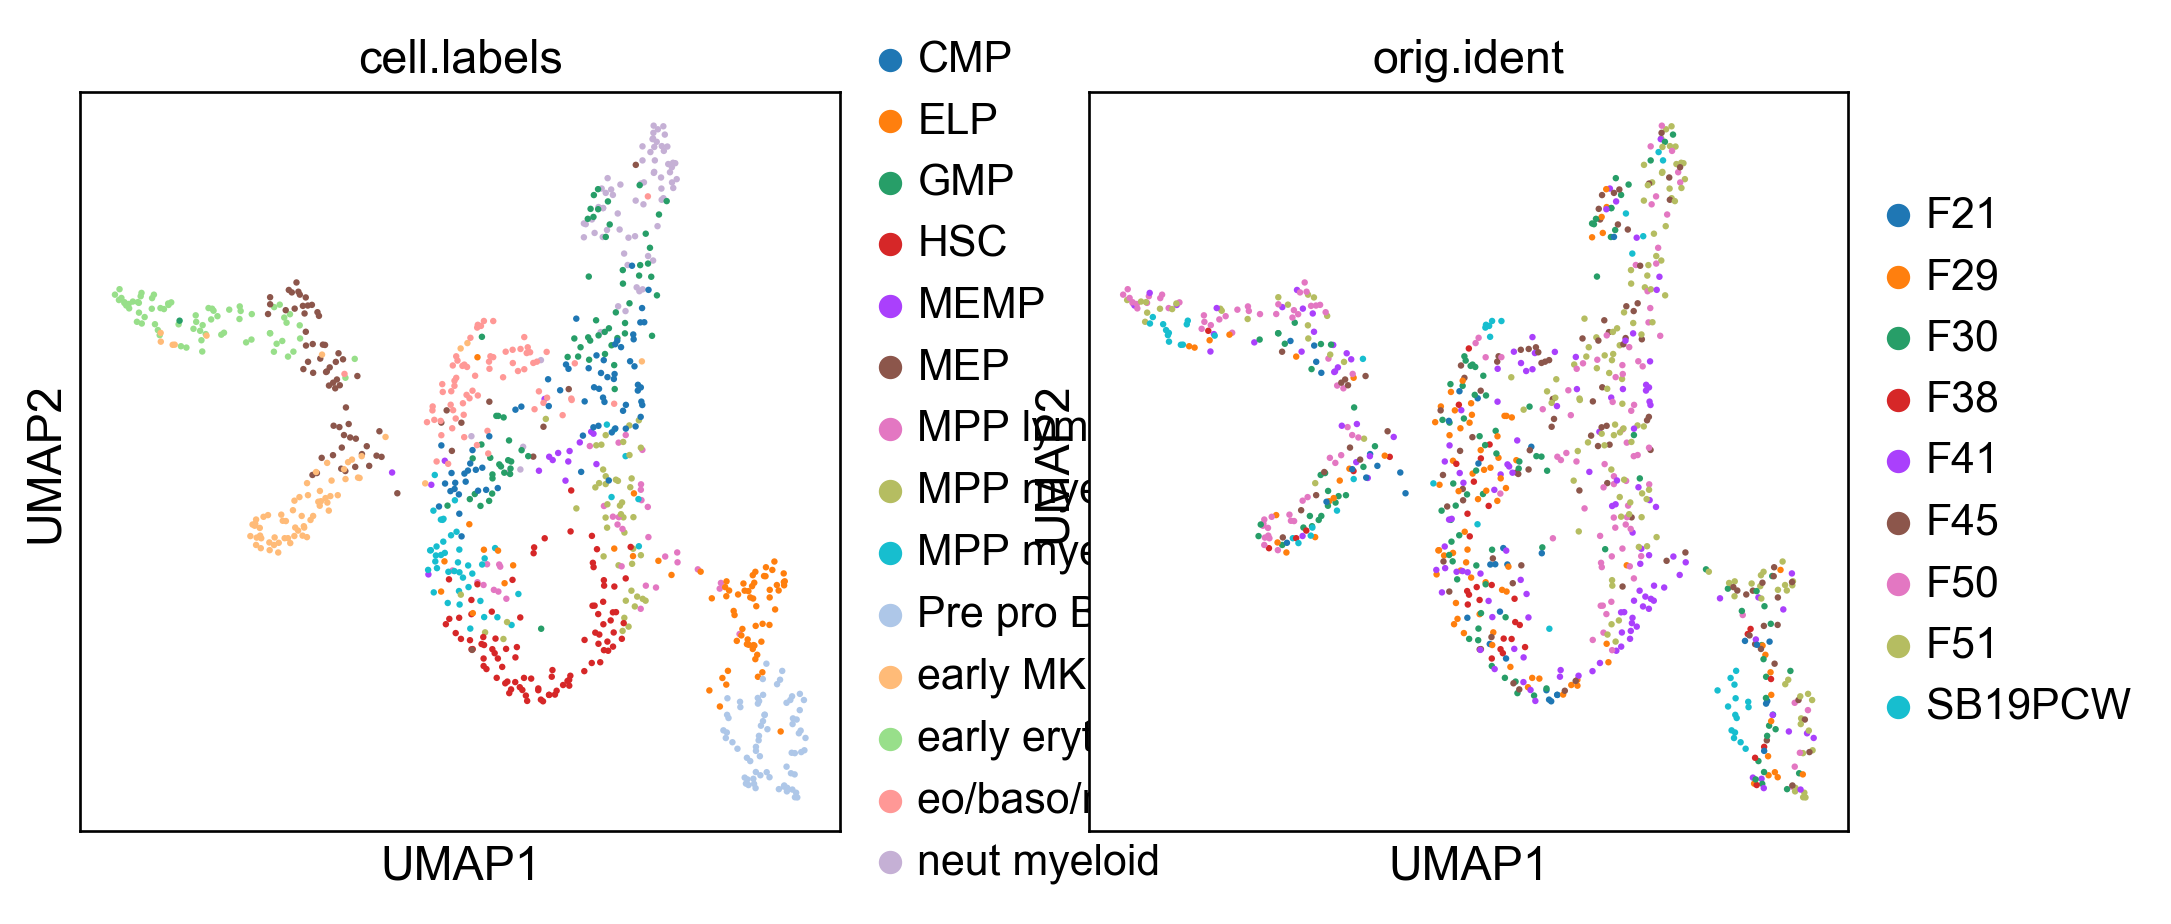

In [25]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident'], size=15) 

# Run harmony batch correction

In [26]:
#harmony prep - save pca and batch (sample) metadata columns 
pca = adata.obsm['X_pca']
batch = adata.obs['orig.ident']

In [27]:
# load up harmony in rpy2
%load_ext rpy2.ipython

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [28]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)

hem = HarmonyMatrix(pca, batch, theta=3, verbose=TRUE, do_pca=FALSE)
hem = data.frame(hem)

R[write to console]: Loading required package: Rcpp

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[

R[write to console]: Harmony 7/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write t

In [29]:
# save old pca values or orig.pca and save batch corrected pca results in anndata object as x_pca
adata.obsm['X_orig_pca'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = hem.values

# Add dimensional reduction post-harmony

In [30]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=10) 

In [31]:
# run umap
sc.tl.umap(adata) 

In [32]:
# run fdg 
# As an input, FDG requires PCA coordinates and a snn graph. must redo snn graph if re-running fdg on subsets 
sc.tl.draw_graph(adata, init_pos='X_pca', layout='fa')

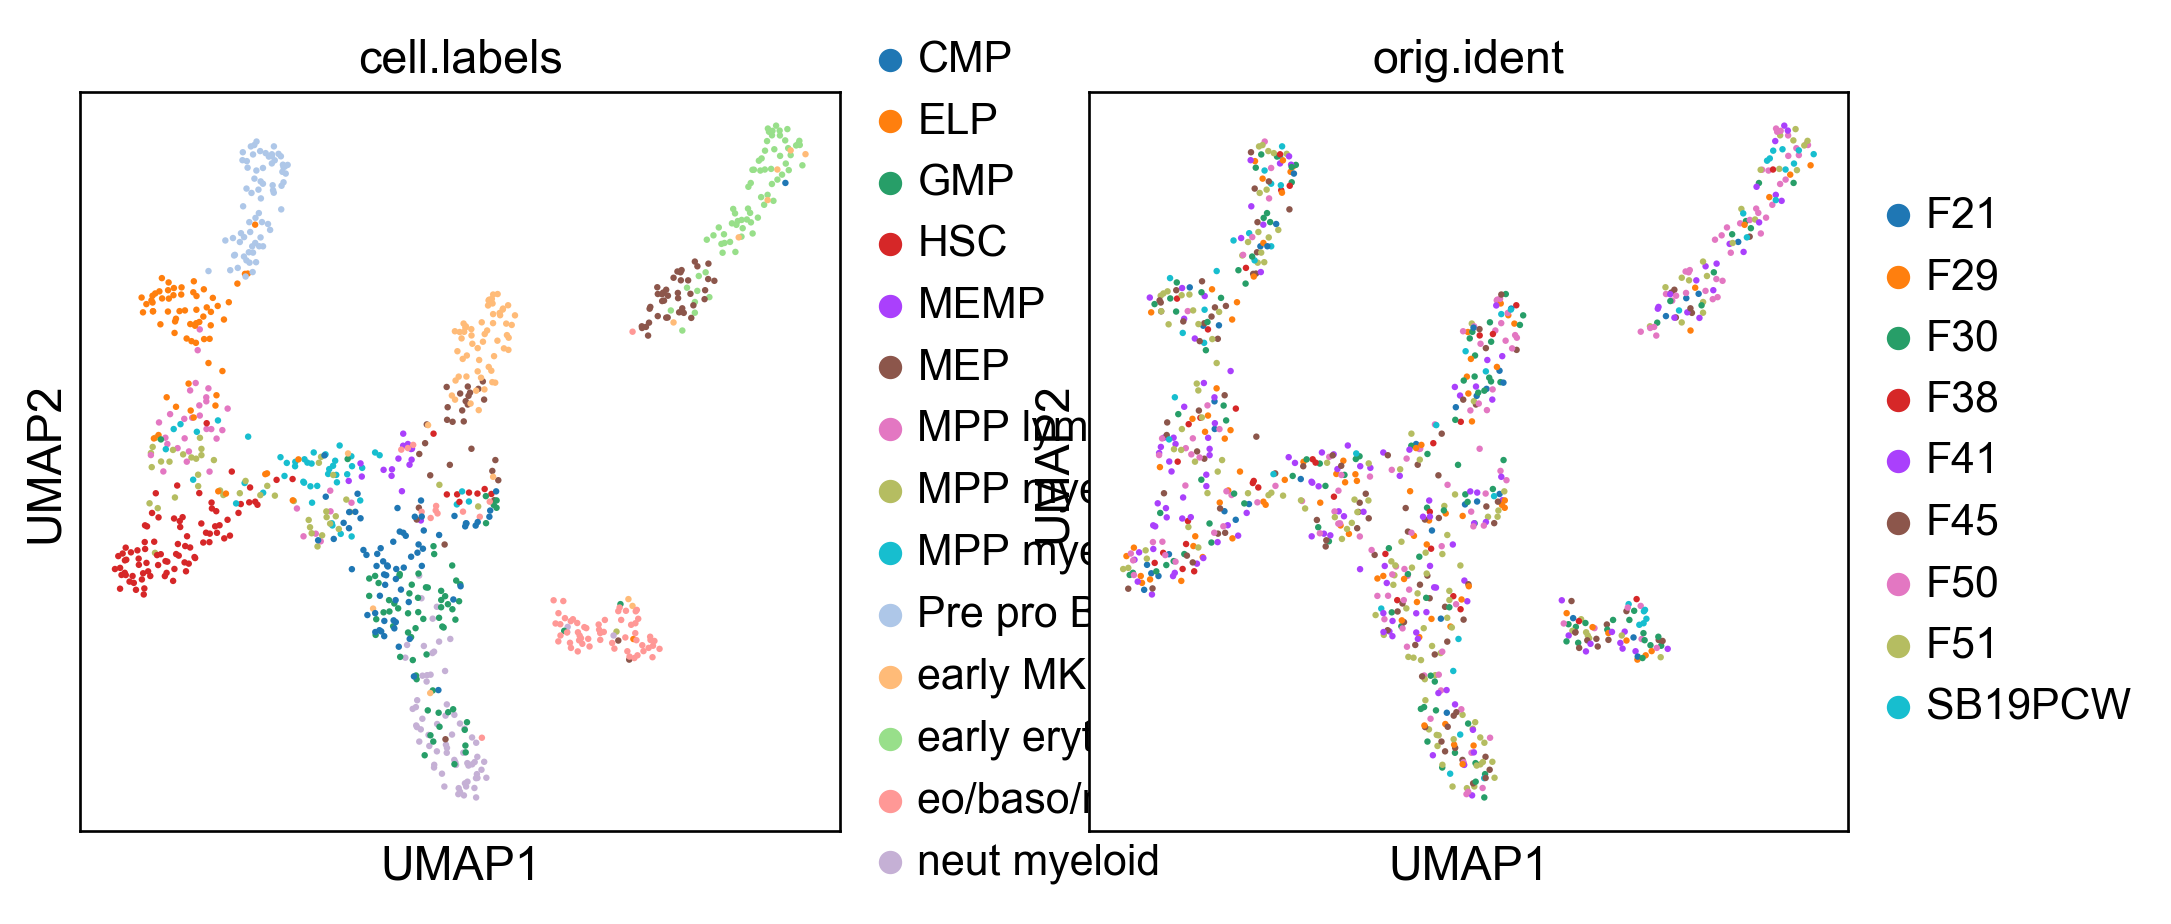

In [33]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident',], size=15) 

# Change the colours for the progen lineage

In [34]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['CMP', 'ELP', 'GMP', 'HSC', 'MEMP', 'MEP', 'MPP lymphoid', 'MPP myeloid 1', 'MPP myeloid 2', 'Pre pro B progenitor', 'early MK', 'early erythroid', 'eo/baso/mast precursor', 'neut myeloid'], dtype='object')

In [35]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].cat.reorder_categories([
                    'HSC', 'MEMP', 
                    'MEP', 'early MK', 'eo/baso/mast precursor', 'early erythroid',  
                    'MPP myeloid 1', 'MPP myeloid 2', 'CMP', 'GMP', 'neut myeloid', 
                    'MPP lymphoid', 'ELP', 'Pre pro B progenitor'])

In [36]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['HSC', 'MEMP', 'MEP', 'early MK', 'eo/baso/mast precursor', 'early erythroid', 'MPP myeloid 1', 'MPP myeloid 2', 'CMP', 'GMP', 'neut myeloid', 'MPP lymphoid', 'ELP', 'Pre pro B progenitor'], dtype='object')

In [37]:
adata.obs["cell.labels"].cat.categories[10]

'neut myeloid'

In [38]:
new_colors = np.empty(len(adata.obs["cell.labels"].cat.categories), dtype=object) 

new_colors[[0]] = '#1B4794' # HSC,2
new_colors[[1]] = '#87288A' # MEMP
new_colors[[2]] = '#AD83BB' # MEP
new_colors[[3]] = '#F3C3DB' # early MK
new_colors[[4]] = '#D43D6A' # eo/baso/mast
new_colors[[5]] = '#A0A0A0' # early eryth
new_colors[[6]] = '#64C5E4' # MPP myeloid 1
new_colors[[7]] = '#64C5E4' # MPP myeloid 2
new_colors[[8]] = '#F9F06C' # CMP
new_colors[[9]] = '#F59771' # GMP
new_colors[[10]] = '#F9414F' # neut myeloid
new_colors[[11]] = '#0B773C' # MPP lymphoid
new_colors[[12]] = '#D1DB94' # ELP
new_colors[[13]] = '#81C678' # Pre pro b progenitor

adata.uns["cell.labels_colors"] = new_colors
new_colors

array(['#1B4794', '#87288A', '#AD83BB', '#F3C3DB', '#D43D6A', '#A0A0A0',
       '#64C5E4', '#64C5E4', '#F9F06C', '#F59771', '#F9414F', '#0B773C',
       '#D1DB94', '#81C678'], dtype=object)

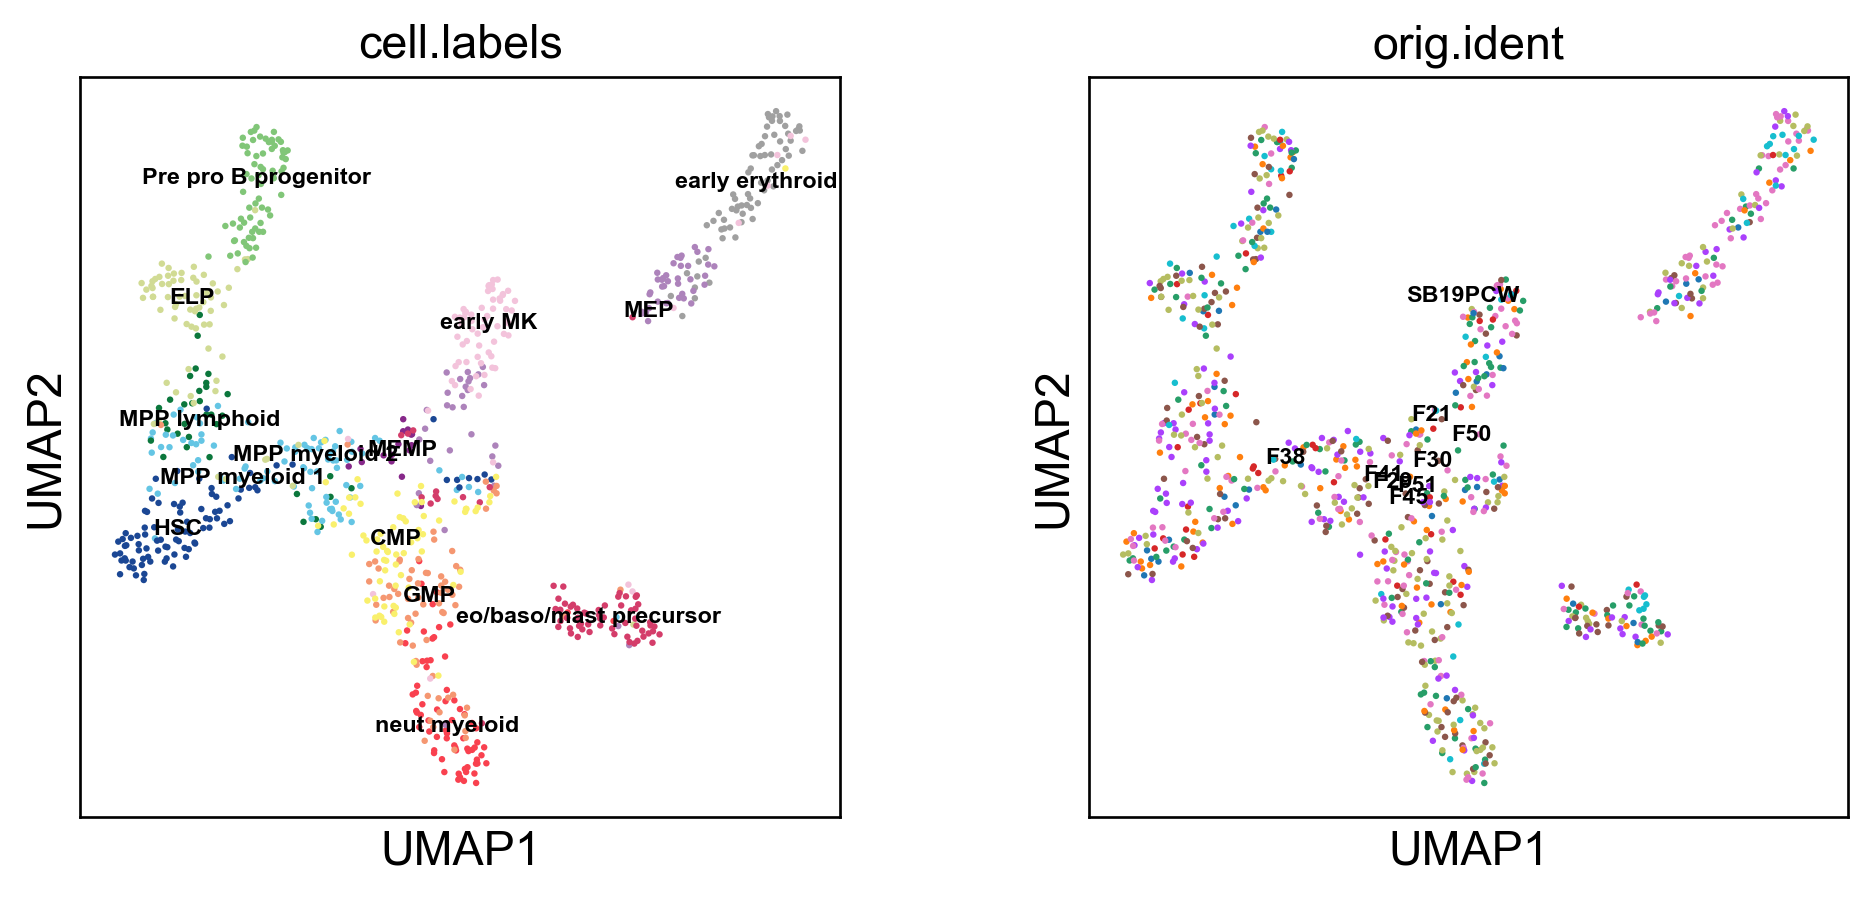

In [39]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident'], size=15, legend_loc="on data", legend_fontsize=7) 

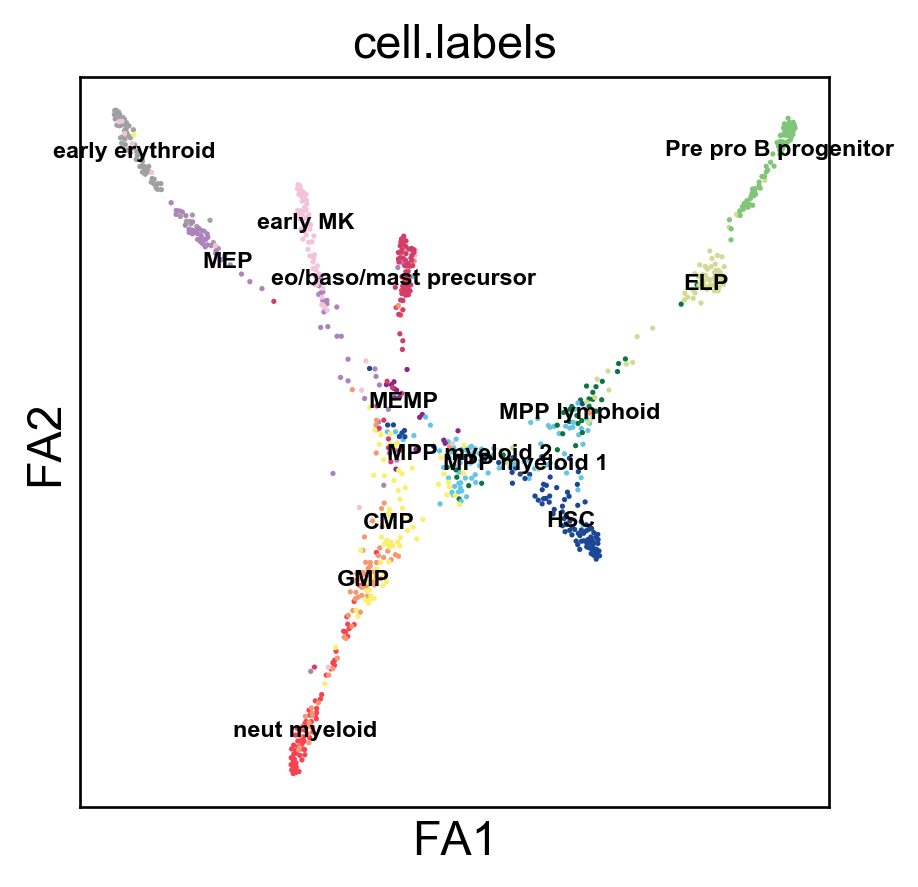

In [40]:
sc.pl.draw_graph(adata, color='cell.labels', legend_loc='on data', legend_fontsize=7, size=10) 

# Save plots

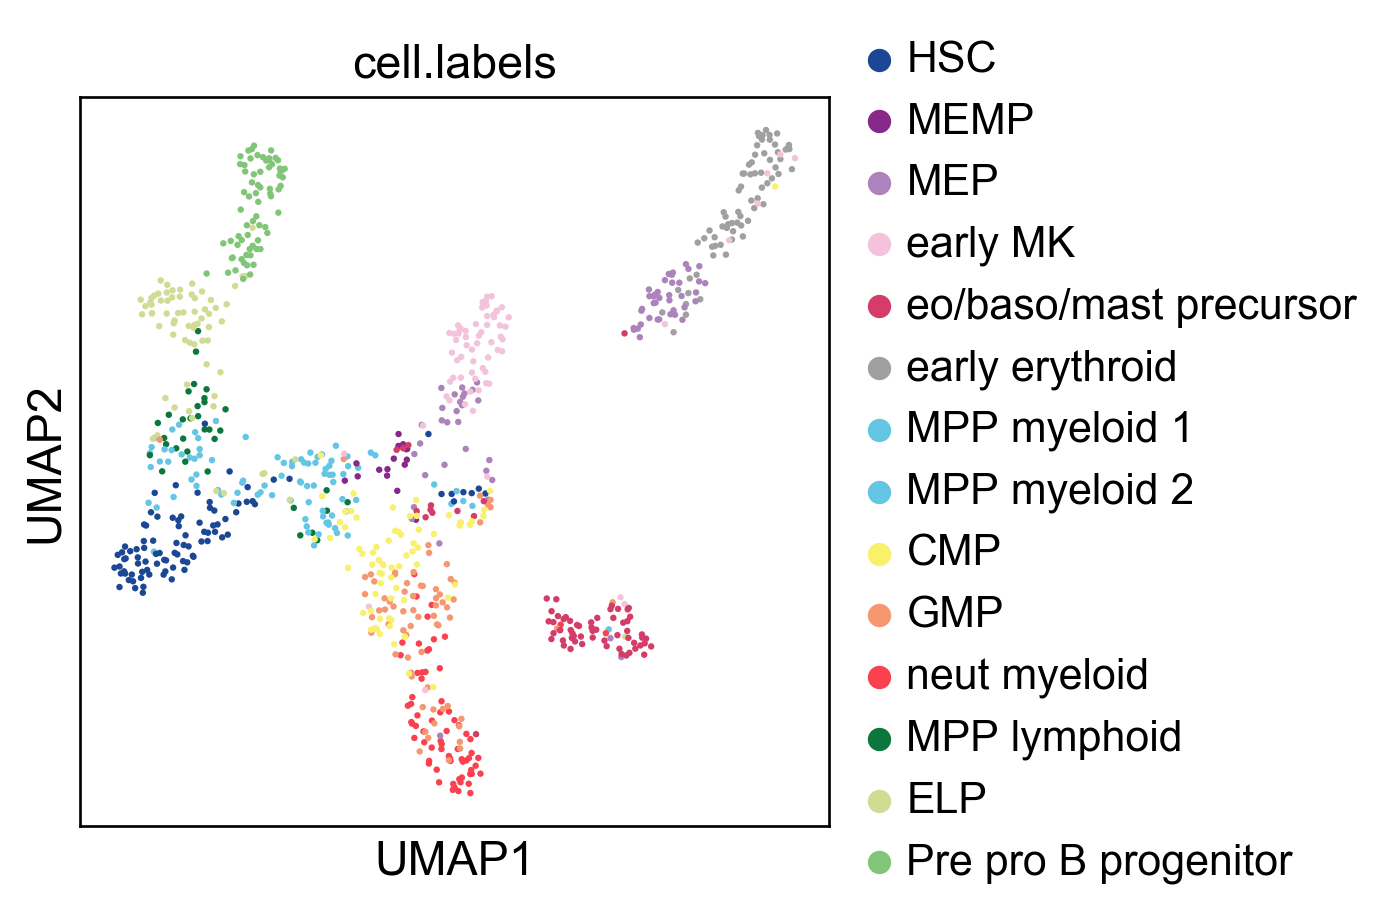

In [41]:
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.pl.umap(adata, color=['cell.labels'], size=15, save="fig5c_progen_hsc_umap_20200520.pdf") 

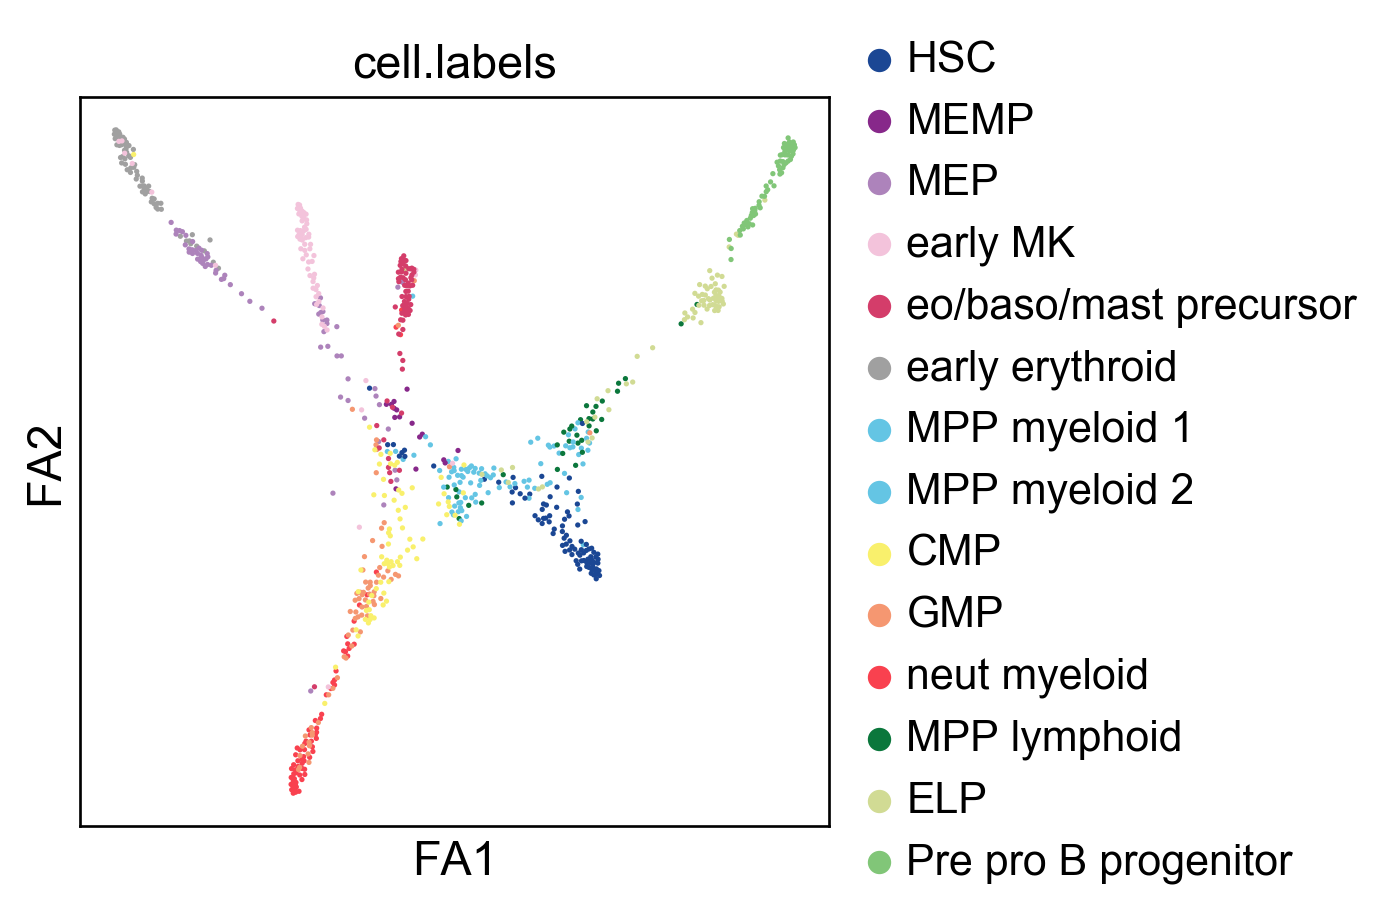

In [42]:
sc.pl.draw_graph(adata, color='cell.labels', layout='fa', show=True, save='_fig5c_hsc_progen_fdg_20200520.pdf', size=10)

In [43]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
HSC                       92
MEMP                      16
MEP                       70
early MK                  70
eo/baso/mast precursor    70
early erythroid           70
MPP myeloid 1             46
MPP myeloid 2             46
CMP                       70
GMP                       70
neut myeloid              70
MPP lymphoid              34
ELP                       70
Pre pro B progenitor      70
dtype: int64

# Run some violin plots

In [44]:
lymphoid_genes = ['CLEC9A', 'CD34', 'MLLT3', 'BCL11A', 'IL2RG', 'IRF8', 'SOX4', 'IL7R']
lymphoid_celltypes = ['HSC', 'MPP lymphoid', 'ELP', 
                      'Pre pro B progenitor']

myeloid_genes = ['HLA-DRA', 'LYZ', 'CLEC11A', 'AZU1', 'MPO', 'IRF8', 'CEBPA', 'CSF1R']
myeloid_celltypes = ['HSC', 'MPP myeloid 1', 'MPP myeloid 2', 
                     'CMP', 'GMP', 'neut myeloid']

erythroid_genes = ['IL1B', 'CTNNBL1', 'TESPA1', 'KLF1', 'GATA1', 'ITGA2B', 'IL1RL1', 'GATA2']
erythroid_celltypes = ['HSC', 'MEMP', 'MEP', 'early MK', 
                       'eo/baso/mast precursor', 'early erythroid']

## Lymphoid

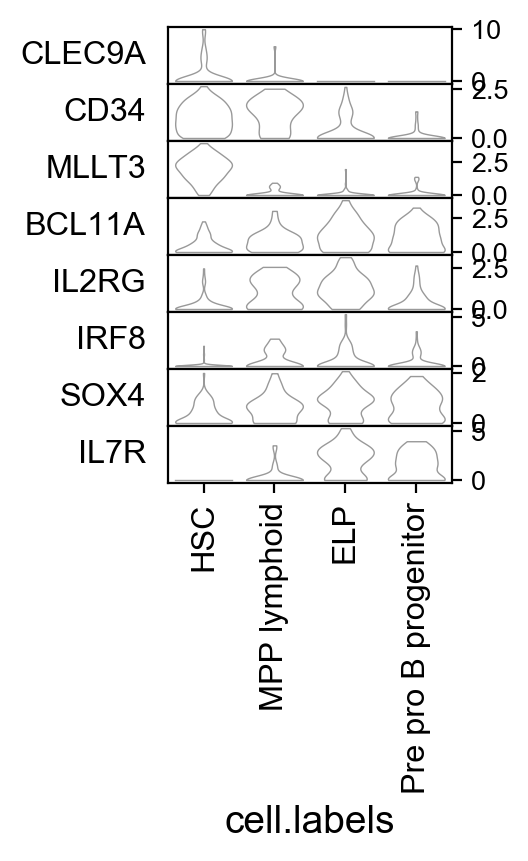

In [45]:
sc.settings.set_figure_params(dpi=100, dpi_save=1000)

subset = adata[adata.obs['cell.labels'].isin(lymphoid_celltypes)].copy()
subset.obs["cell.labels"] = subset.obs["cell.labels"].cat.reorder_categories(lymphoid_celltypes)

sc.pl.stacked_violin(subset, var_names=lymphoid_genes, save="progen_fate_lymphoid_genes_violin_20200520.pdf", 
                     swap_axes=True,
                     groupby='cell.labels', use_raw=False, figsize=(2,3),
                     row_palette=['#ffffff'])

## Myeloid

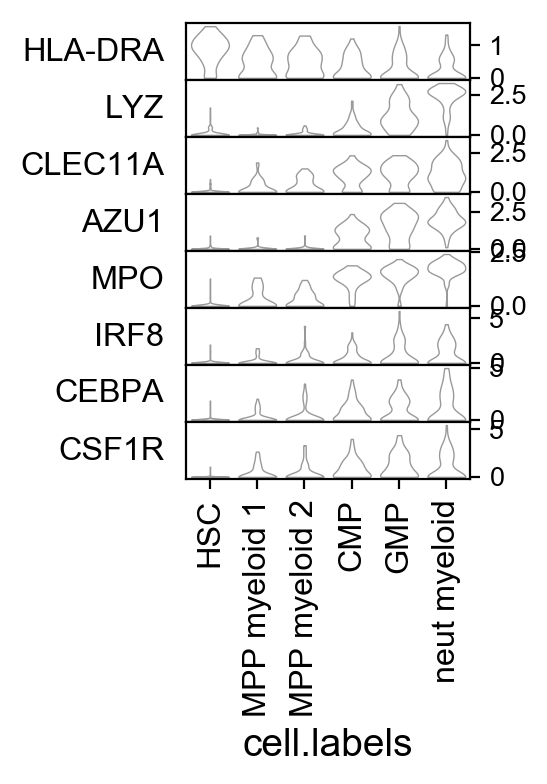

In [46]:
sc.settings.set_figure_params(dpi=100, dpi_save=1000)

subset = adata[adata.obs['cell.labels'].isin(myeloid_celltypes)].copy()
subset.obs["cell.labels"] = subset.obs["cell.labels"].cat.reorder_categories(myeloid_celltypes)

sc.pl.stacked_violin(subset, var_names=myeloid_genes, save="progen_fate_myeloid_genes_violin_20200520.pdf", 
                     swap_axes=True,
                     groupby='cell.labels', use_raw=False, figsize=(2,3), 
                     row_palette=['#ffffff'])

## Erythroid

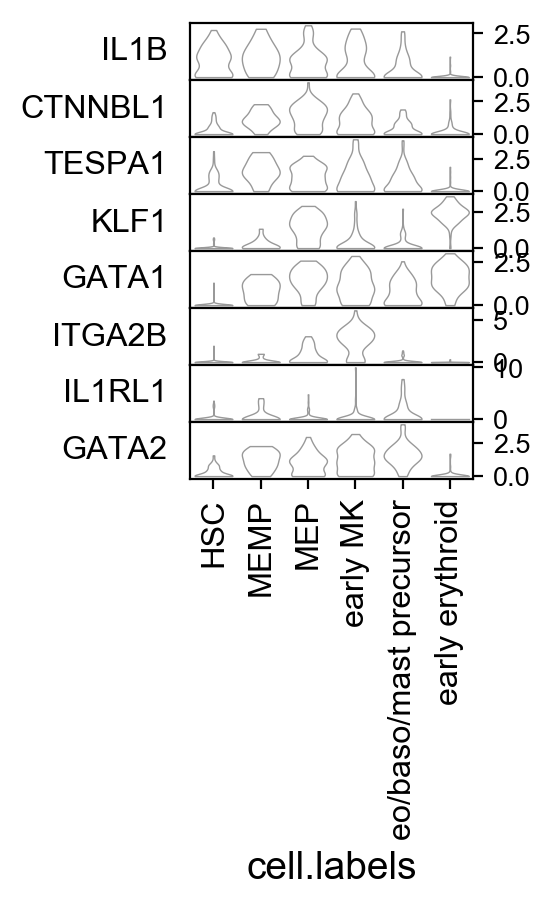

In [47]:
sc.settings.set_figure_params(dpi=100, dpi_save=1000)

subset = adata[adata.obs['cell.labels'].isin(erythroid_celltypes)].copy()
subset.obs["cell.labels"] = subset.obs["cell.labels"].cat.reorder_categories(erythroid_celltypes)

sc.pl.stacked_violin(subset, var_names=erythroid_genes, save="progen_fate_erythroid_genes_violin_20200520.pdf", 
                     swap_axes=True,
                     groupby='cell.labels', use_raw=False, figsize=(2,3), 
                     row_palette=['#ffffff'])

# Save the data

In [48]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [49]:
adata.X

<864x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 2792967 stored elements in Compressed Sparse Row format>

In [50]:
adata.raw.X

<864x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 3216436 stored elements in Compressed Sparse Row format>

In [51]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/fig5c_hsc_progen_dr_20200520.h5ad")

# Reload data and run a combined violin

In [15]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
# silence NumbaPerformanceWarning
import warnings
from numba.errors import NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

In [16]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==0.23.4 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [17]:
adata=sc.read("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/fig5c_hsc_progen_dr_20200520.h5ad")

In [18]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
HSC                       92
MEMP                      16
MEP                       70
early MK                  70
eo/baso/mast precursor    70
early erythroid           70
MPP myeloid 1             46
MPP myeloid 2             46
CMP                       70
GMP                       70
neut myeloid              70
MPP lymphoid              34
ELP                       70
Pre pro B progenitor      70
dtype: int64

In [19]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].replace(["MPP myeloid 1", "MPP myeloid 2"],["MPP myeloid", 
                                                                                               "MPP myeloid"])

In [20]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CMP                       70
ELP                       70
GMP                       70
HSC                       92
MEMP                      16
MEP                       70
MPP lymphoid              34
MPP myeloid               92
Pre pro B progenitor      70
early MK                  70
early erythroid           70
eo/baso/mast precursor    70
neut myeloid              70
dtype: int64

In [21]:
overall_genes = ['CLEC9A', 'CD34', 'SPINK2', 'KLF1', 'ITGA2B', 'GATA2', 'MPO', 'CSF1R', 'CEBPA',
                'BCL11A', 'IL7R', 'IL2RG']

overall_celltypes = ['HSC', 'MEMP', 'MEP', 'early MK', 'eo/baso/mast precursor', 'early erythroid',
                    'MPP myeloid', 'CMP', 'GMP', 'neut myeloid', 'MPP lymphoid', 'ELP', 'Pre pro B progenitor']

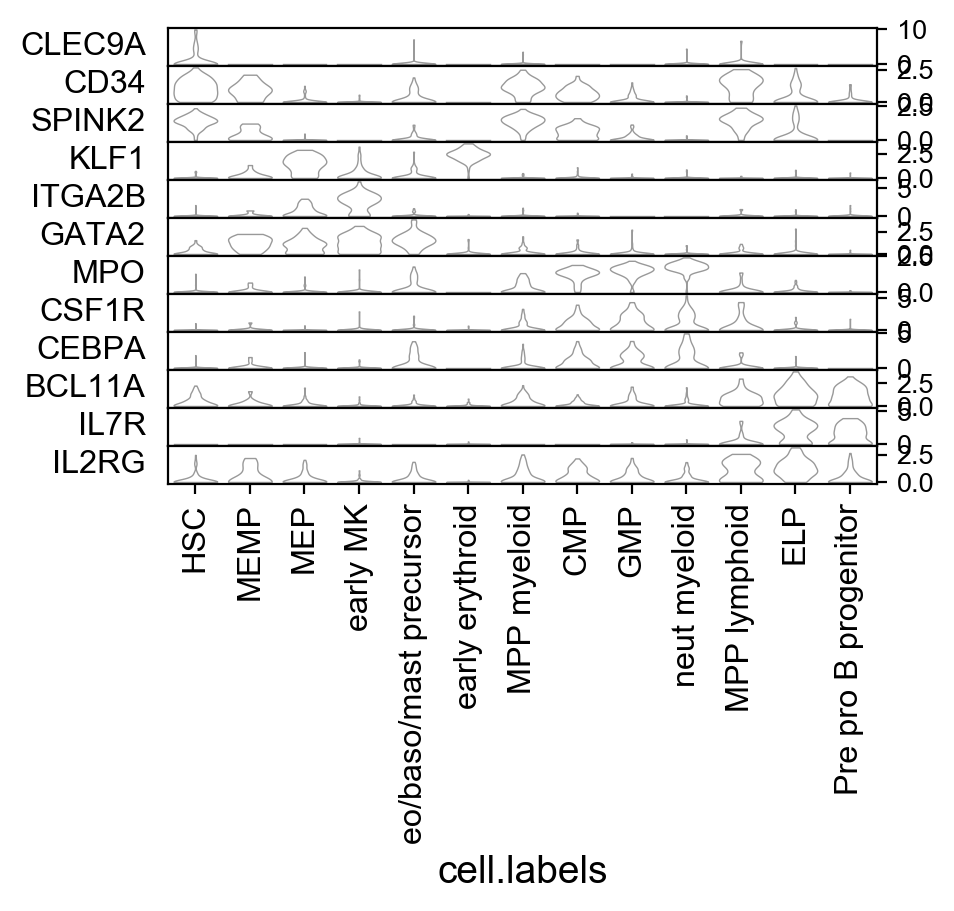

In [22]:
sc.settings.set_figure_params(dpi=100, dpi_save=1000)

subset = adata
subset.obs["cell.labels"] = subset.obs["cell.labels"].astype('category')
subset.obs["cell.labels"] = subset.obs["cell.labels"].cat.reorder_categories(overall_celltypes)

sc.pl.stacked_violin(subset, var_names=overall_genes, save="progen_fate_overal_genes_violin_20200521.pdf", 
                     swap_axes=True,
                     groupby='cell.labels', use_raw=False, figsize=(5,3), 
                     row_palette=['#ffffff'])